In [1]:
!pip install yfinance
!pip install yahooquery
!pip install tvdatafeed
!pip install tensorflow
!pip install mplfinance
!pip install cairocffi
from tvDatafeed import TvDatafeed, Interval
from yahooquery import Screener
import yfinance as yf   
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random 
from tensorflow.keras.models import load_model
import os
import shutil
import mplfinance as mpl 
from datetime import datetime
import glob
from PIL import Image
import cv2
%matplotlib notebook
import gc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('agg')
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,AveragePooling2D,GlobalAveragePooling2D
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
def work_with_dir():
  if os.path.exists("/content/data/"):
    shutil.rmtree("/content/data/", ignore_errors=True)
    print("Data Folder Removed")
    os.mkdir("/content/data/")
  if not os.path.exists("/content/data/"):
    os.mkdir("/content/data/")
  if not os.path.exists("/content/extracted/"):
    os.mkdir("/content/extracted/")
  if not os.path.exists("/content/checkpoints/"):
    os.mkdir("/content/checkpoints/")
def get_crypto_syms():
   screens = [
       'all_cryptocurrencies_us', 'all_cryptocurrencies_au', 'all_cryptocurrencies_ca', 'all_cryptocurrencies_eu', 'all_cryptocurrencies_gb', 'all_cryptocurrencies_in', ]
   s = Screener()
   symbols = []
   for i in screens:
      data = s.get_screeners(i, count=250)
      dicts = data[i]['quotes']
      syms = [d['symbol'] for d in dicts]
      for sym in syms:
        symbols.append(sym)
   return symbols
def download_data(symbols, periodd, intervall):
  indexx = 100
  work_with_dir()
  for symbol in symbols:
    if ((symbols.index(symbol)+1) % 100 == 0):
      print(f" -- {indexx}", end="")
      indexx = indexx + 100
    try:
        data = yf.download(symbol, period=periodd,
                           interval=intervall, progress=False, show_errors=False)
        if data.empty:
           pass
        else:
            data.to_csv(f"/content/data/{symbol}.csv")
    except:
       print("Error!")
  print(" ")
def extract_data(how_many_future_candles, how_many_past_candles, each_row_past):
  print(f"Files In Data : {len(os.listdir('/content/data/'))}")
  pd.options.mode.chained_assignment = None
  files = os.listdir("/content/data/")
  print("Processing File:")
  now = datetime.now().strftime("%H%M%S")
  os.mkdir(f"/content/extracted/{now}/")
  index = 1
  for file in files:
     print(f"File Number {index}:", end=" ")
     each_file_proc(file, now, how_many_future_candles,
                    how_many_past_candles, each_row_past)
     index = index + 1
  print(" ")
  return now
def each_file_proc(file, now, how_many_future_candles, how_many_past_candles, each_row_past):
    address = f"/content/data/{file}"
    data = pd.read_csv(address)
    if len(data.columns) == 7:
      data = data.iloc[:, 1:]
    data = np.array(data)
    data = data.astype(float)
    max_index = data.shape[0]-which_future_or_past
    for i in range(each_row_past,max_index):
        rows = data[i-each_row_past:i, :]

        next_candles = []
        for z in range(0, how_many_future_candles):
          next_candles.append(data[i+z][3]-data[i+z][0])
        next_candles = sum(next_candles)
        if next_candles > 0:
          sugg = 1
        else:
          sugg = 0

        df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])

        df.index.name = "Date"

        df.index = pd.to_datetime(df.index)
        right_now = datetime.now().strftime("%H%M%S%f")
        address = f"/content/extracted/{now}/{right_now}_{sugg}.png"
        

        fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
        
        fig.savefig(address)
        fig.clf()

        if i % 10 == 0:
            print(f"{i}/{max_index}", end=" ")
        if i % 20:
          plt.close("all")
        if i % 270 ==0:
          print("")
    plt.close("all")
    print("")

def start(how_many_future_candles, how_many_past_candles, each_row_past):
    folder_name = extract_data(
        how_many_future_candles, how_many_past_candles, each_row_past)
    return folder_name

In [33]:
symbols = get_crypto_syms()
print(f"Symbols : {len(symbols)}")
symbols = ["btc-usd","eth-usd","trx-usd","ltc-usd","xrp-usd","bnb-usd"]
download_data(symbols,"7d","5m")

Symbols : 1500
Data Folder Removed
 


In [ ]:
how_many_future_candles = 15
how_many_past_candles = 1
each_row_past = 85


global which_future_or_past
which_future_or_past = None
if how_many_future_candles > how_many_past_candles:
    which_future_or_past = how_many_future_candles
else:
    which_future_or_past = how_many_past_candles
folder_name = start(how_many_future_candles,how_many_past_candles,each_row_past)
len(os.listdir(f"/content/extracted/{folder_name}"))

In [35]:
folder_name = "165913"

shutil.make_archive(folder_name,"zip",f"/content/extracted/{folder_name}/")
#shutil.unpack_archive(f"/content/{folder_name}.zip",f"/content/extracted/{folder_name}")
label = []
data  = []
files = os.listdir(f"/content/extracted/{folder_name}/")
for i, image_name in enumerate(files):
  if image_name.split(".")[1] == "png":
    image = cv2.imread(f"/content/extracted/{folder_name}"+"/"+image_name,0)
    dim = (100, 100)
    resized = cv2.resize(image, dim)
    data.append(np.array(resized))
    sugg = image_name.split("_")[1].split(".")[0]
    label.append(int(sugg))
data = np.array(data)
data = data / 255
print(data.shape)
xTrain , xTest , yTrain , yTest = train_test_split(data,label,test_size=0.2,random_state=99)
data = None
label = None
print(f"xTrain : {len(xTrain)} \\ xTest : {len(xTest)}")
nytrain = []
nytest = []
yn = 0
nn = 0
for i in yTrain:
  if i == 1:
    nytrain.append([1,0])
    yn += 1
  else:
    nytrain.append([0,1])
    nn += 1
for i in yTest:
  if i == 1:
    nytest.append([1,0])
    yn += 1
  else:
    nytest.append([0,1])
    nn += 1
yTrain = np.array(nytrain)
yTest = np.array(nytest)
print(f"yn: {yn} nn: {nn}")

(5594, 100, 100)
xTrain : 4475 \ xTest : 1119
yn: 2894 nn: 2700


In [36]:
model = Sequential()

model.add(Conv2D(128,     (2, 2),activation="relu", input_shape=(xTrain.shape[1], xTrain.shape[2],1)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32,      (2, 2),activation="relu",)) 
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,      (2, 2),activation="relu",)) 
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,      (2, 2),activation="relu",)) 
model.add(Flatten())
model.add(Dense(800,activation="relu"))
model.add(Dense(800,activation="relu"))
model.add(Dense(750,activation="relu"))
model.add(Dense(750,activation="relu"))
model.add(Dense(2,activation="sigmoid"))

adamax = tf.keras.optimizers.Adamax(
    learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adamax,
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 99, 99, 128)       640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 33, 33, 128)      0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        16416     
                                                                 
 average_pooling2d_9 (Averag  (None, 16, 16, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_23 (Conv2D)          (None, 15, 15, 32)        4128      
                                                                 
 average_pooling2d_10 (Avera  (None, 7, 7, 32)        

In [37]:
filepath = "/content/checkpoints/{epoch:02d}-{val_accuracy:.2f}.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#model.fit(xTrain,yTrain,batch_size=64,epochs=30,validation_data=(xTest,yTest), callbacks=model_checkpoint_callback)
model.fit(xTrain,yTrain,batch_size=16,epochs=20,validation_data=(xTest,yTest))

Epoch 1/20
280/280 [==============================] - 88s 307ms/step - loss: 0.6930 - accuracy: 0.5124 - val_loss: 0.6923 - val_accuracy: 0.5210
Epoch 2/20
280/280 [==============================] - 87s 311ms/step - loss: 0.6934 - accuracy: 0.5191 - val_loss: 0.6912 - val_accuracy: 0.5210
Epoch 3/20
280/280 [==============================] - 79s 282ms/step - loss: 0.6750 - accuracy: 0.5638 - val_loss: 0.6595 - val_accuracy: 0.6157
Epoch 4/20
280/280 [==============================] - 80s 284ms/step - loss: 0.6414 - accuracy: 0.6346 - val_loss: 0.5947 - val_accuracy: 0.6917
Epoch 5/20
280/280 [==============================] - 78s 278ms/step - loss: 0.5499 - accuracy: 0.7274 - val_loss: 0.5034 - val_accuracy: 0.7712
Epoch 6/20
280/280 [==============================] - 78s 279ms/step - loss: 0.4149 - accuracy: 0.8188 - val_loss: 0.4458 - val_accuracy: 0.7962
Epoch 7/20
280/280 [==============================] - 77s 274ms/step - loss: 0.3317 - accuracy: 0.8623 - val_loss: 0.3992 - val_ac

In [ ]:
model.save(f"1.h5")

[*********************100%***********************]  1 of 1 completed
                                   Open          High           Low  \
Datetime                                                              
2022-07-20 00:00:00+00:00  23394.804688  23394.804688  23387.771484   
2022-07-20 00:05:00+00:00  23394.300781  23394.300781  23376.093750   
2022-07-20 00:10:00+00:00  23402.453125  23402.453125  23309.650391   
2022-07-20 00:15:00+00:00  23252.806641  23252.806641  23249.259766   
2022-07-20 00:20:00+00:00  23256.517578  23256.517578  23242.560547   
...                                 ...           ...           ...   
2022-07-29 17:20:00+00:00  23781.285156  23781.285156  23764.376953   
2022-07-29 17:25:00+00:00  23717.076172  23717.076172  23701.664062   
2022-07-29 17:30:00+00:00  23687.488281  23726.460938  23683.484375   
2022-07-29 17:35:00+00:00  23721.031250  23729.652344  23721.031250   
2022-07-29 17:40:00+00:00  23759.691406  23759.691406  23759.691406   

       

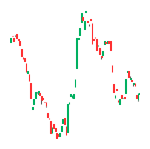

In [47]:
symbol,period,interval="btc-usd","10d","5m"
data = yf.download(tickers=symbol,period=period,interval=interval)
print(data)
data = np.array(data)
data = data.astype(float)
i = -1
rows = data[i-each_row_past:i, :]
df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])
df.index.name = "Date"
df.index = pd.to_datetime(df.index)
fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
fig.savefig("picture.png")

In [48]:
image = cv2.imread("/content/picture.png",0)
dim = (100, 100)
resized = cv2.resize(image, dim)
data = np.array(resized)
model.predict([[data.reshape(1,100,100,1)]])

array([[0., 1.]], dtype=float32)

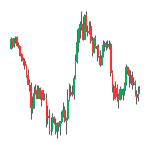

In [45]:
tv = TvDatafeed()
data = tv.get_hist(symbol="btcusdt",exchange="binance",interval=Interval.in_5_minute,n_bars=1000)
data = np.array(data)
i = -1
rows = data[i-each_row_past:i, 1:5]
rows.shape
df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close"])
df.index.name = "Date"
df.index = pd.to_datetime(df.index)
df = df.apply(lambda col:pd.to_numeric(col, errors='coerce'))
fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
fig.savefig("picture1.png")

In [46]:
image = cv2.imread("/content/picture1.png",0)
dim = (100, 100)
resized = cv2.resize(image, dim)
data = np.array(resized)
model.predict([[data.reshape(1,100,100,1)]])

array([[0., 1.]], dtype=float32)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
lst = []
while True:
  ans = input()
  if ans == "exit":
    break
  lst.append(int(ans))
print(sum(max),len(lst))